# LLM Judgment - Human Judgment as a Target

This experiments applied the signed differecnes of LLM labels and human labels as a target for analysis the features.

In [19]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf

### Plots for Model Assumptions

In [20]:
## Function to check model assumptions 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_residuals(result):
    
    # Extract residuals and fitted values
    residuals = result.resid
    fitted_values = result.fittedvalues

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs. Fitted values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

### Plot for Coefficients

In [21]:
def plot_coef(result):
    
    # Step 1: Extract the coefficients and p-values
    coefficients = result.params
    p_values = result.pvalues

    print("Coefficients from the model:")
    print("P-values from the model:")

    # Step 2: Plot the coefficients with p-values
    # Convert coefficients and p-values to a DataFrame for easy plotting
    coeff_df = pd.DataFrame({
        'coefficients': coefficients,
        'p_values': p_values,
        'features': coefficients.index
    })

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(coeff_df['features'], coeff_df['coefficients'], color='skyblue')

    # Add the p-values as text annotations next to each bar
    for bar, p_value in zip(bars, coeff_df['p_values']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'p = {p_value:.3f}', 
                va='center', ha='left', fontsize=10)

    # Add titles and labels
    plt.title('Extracted Coefficients with P-Values from the Model')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.grid(True)

    # Display the plot
    plt.show()

### Data

In [22]:
# Load each text file into a DataFrame
qrel_human_df = pd.read_csv('./qrels/2023.qrels.pass.withDupes.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])  # adjust delimiter if necessary
qrel_llm_df = pd.read_csv('./qrels/2023.qrels.pass.gpt4.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])

# Merge the two DataFrames based on a common column, e.g., 'id'
qrels_df = pd.merge(qrel_human_df, qrel_llm_df, on=['qid', 'docid'])

qrels_df.drop(['Q0_x'], axis=1, inplace=True)
qrels_df.drop(['Q0_y'], axis=1, inplace=True)

qrels_df.rename(columns={'label_x': 'label_human'}, inplace=True)
qrels_df.rename(columns={'label_y': 'label_llm'}, inplace=True)

qrels_df['llm_human_diff'] = qrels_df['label_llm'] - qrels_df['label_human']

# Display or save the merged DataFrame
# print(qrels_df['llm-human'])

In [23]:
queries_judged = set(qrels_df['qid'])
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [24]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
doc_to_info = pd.read_csv("infos/doc_to_info.txt", sep='\t')

In [25]:
data = pd.merge(qrels_df, qid_to_info, on='qid')
data = pd.merge(data, doc_to_info, on='docid')

In [26]:
data.head(20)
#data.describe

,qid,docid,label_human,label_llm,llm_human_diff,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,DW
0,2001010,msmarco_passage_00_257661787,0,0,0,0,0.784,0.7023,6,72.5291,0,0,56
1,2001010,msmarco_passage_00_257662430,0,0,0,0,0.784,0.7023,6,72.5291,0,0,43
2,2001010,msmarco_passage_00_257664103,0,0,0,0,0.784,0.7023,6,72.5291,0,0,46
3,2001010,msmarco_passage_00_729310942,0,1,1,0,0.784,0.7023,6,72.5291,0,0,47
4,2001010,msmarco_passage_00_729315698,1,1,0,0,0.784,0.7023,6,72.5291,0,0,45
5,2001010,msmarco_passage_00_729382608,1,0,-1,0,0.784,0.7023,6,72.5291,0,0,53
6,2001010,msmarco_passage_00_729386217,1,0,-1,0,0.784,0.7023,6,72.5291,0,0,55
7,2001010,msmarco_passage_00_729411995,1,2,1,0,0.784,0.7023,6,72.5291,0,0,59
8,2001010,msmarco_passage_00_729434403,1,0,-1,0,0.784,0.7023,6,72.5291,0,0,66
9,2001010,msmarco_passage_01_221183941,0,0,0,0,0.784,0.7023,6,72.5291,0,0,66


### Modelling LLM Label 

In [27]:
mixed_model_1 = "label_llm ~ label_human * (QL + QW + DW + isSynthetic)"
mixed_model = "llm_human_diff ~ QL + QW + isSynthetic + DW"
mixed_model_int = "llm_human_diff ~ isSynthetic * (QL + QW + DW)"

In [28]:
model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data["docid"])
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                MixedLM    Dependent Variable:    label_llm  
No. Observations:     24249      Method:                REML       
No. Groups:           21873      Scale:                 0.2773     
Min. group size:      1          Log-Likelihood:        -28585.6240
Max. group size:      324        Converged:             Yes        
Mean group size:      1.1                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.404    0.022  18.267 0.000  0.360  0.447
label_human              0.466    0.023  20.172 0.000  0.420  0.511
QL                      -0.251    0.027  -9.290 0.000 -0.304 -0.198
QW                       0.038    0.004  10.604 0.000  0.031  0.045
DW                      -0.000    0.000  -5.573 0.000 -0.000 -0.000
isSynthetic             -0.087    0.014  -6.426 0.000 -0.114 -0.061
label_human:QL          -0.028    0.025  -1.112 0.266 -0.077  0.021
label_human:QW           0.016    0.003   5.130 0.000  0.010  0.023
label_human:DW           0.000    0.000   0.514 0.607 -0.000  0.001
label_human:isSynthetic -0.142    0.012 -11.375 0.000 -0.166 -0.117
Group Var                0.383    0.039                            
===================================================================

"""

Coefficients from the model:
P-values from the model:


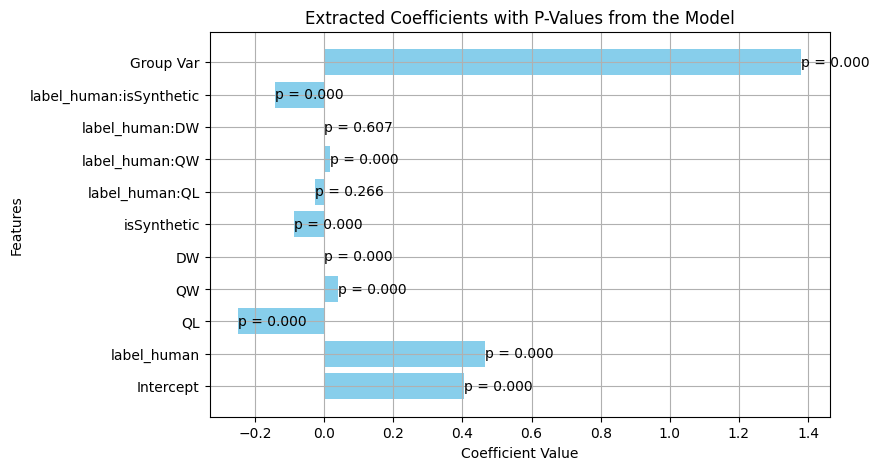

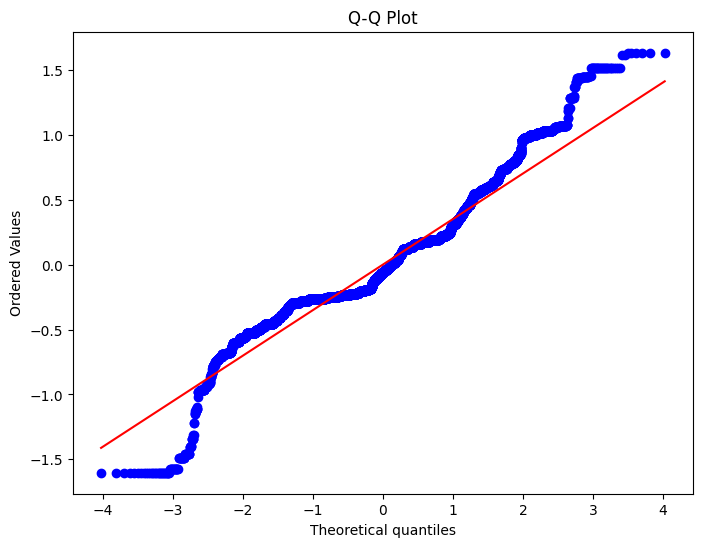

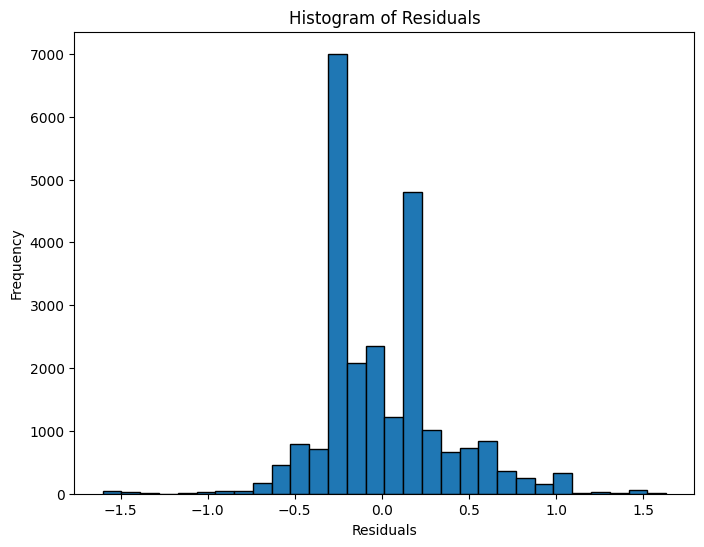

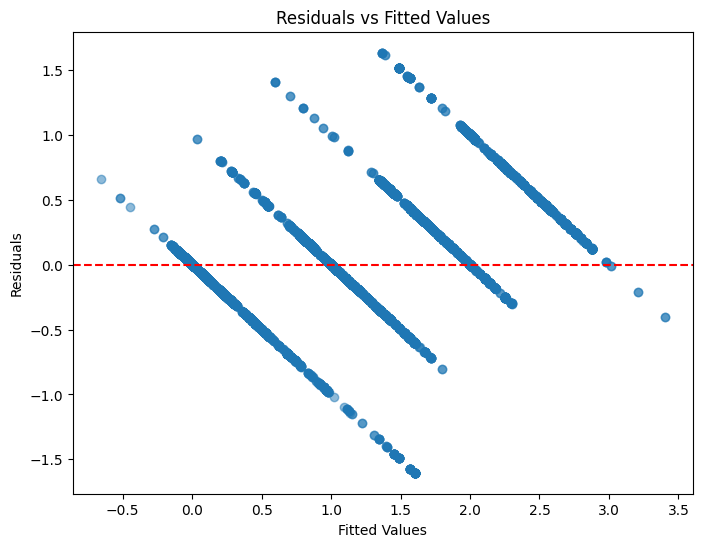

In [29]:
plot_coef(result)
plot_residuals(result)

In [30]:
model = smf.glm(formula=mixed_model_1, data=data, family=sm.families.Poisson())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              label_llm   No. Observations:                24249
Model:                            GLM   Df Residuals:                    24239
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27230.
Date:                Thu, 03 Oct 2024   Deviance:                       22992.
Time:                        11:26:27   Pearson chi2:                 2.18e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2357
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8565      0.036    -23.471      0.000      -0.928      -0.785
label_human                 0.5466      0.025     22.009      0.000       0.498       0.595
QL                         -0.3663      0.046     -8.039      0.000      -0.456      -0.277
QW                          0.0669      0.006     11.368      0.000       0.055       0.078
DW                      -3.516e-06   3.01e-06     -1.166      0.243   -9.42e-06    2.39e-06
isSynthetic                -0.2153      0.022     -9.717      0.000      -0.259      -0.172
label_human:QL              0.1009      0.027      3.745      0.000       0.048       0.154
label_human:QW             -0.0151      0.003     -4.421      0.000      -0.022      -0.008
label_human:DW              0.0003      0.000      1.309      0.191      -0.000       0.001
label_human:isSynthetic    -0.0075      0.013     -0.570      0.569      -0.034       0.018
===========================================================================================
"""

Coefficients from the model:
P-values from the model:


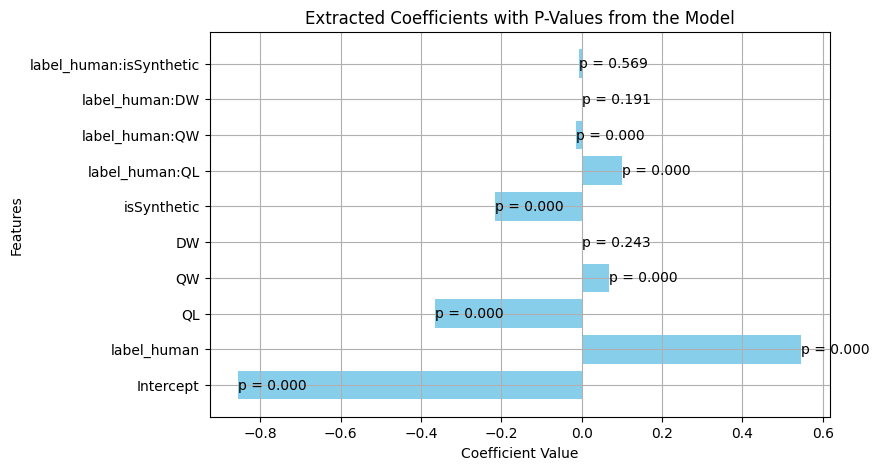

In [31]:
plot_coef(result)

In [33]:
data_log = data.copy()

data_log = np.log(data_log['label_llm'])
model = model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data["docid"])

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                MixedLM    Dependent Variable:    label_llm  
No. Observations:     24249      Method:                REML       
No. Groups:           21873      Scale:                 0.2773     
Min. group size:      1          Log-Likelihood:        -28585.6240
Max. group size:      324        Converged:             Yes        
Mean group size:      1.1                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.404    0.022  18.267 0.000  0.360  0.447
label_human              0.466    0.023  20.172 0.000  0.420  0.511
QL                      -0.251    0.027  -9.290 0.000 -0.304 -0.198
QW                       0.038    0.004  10.604 0.000  0.031  0.045
DW                      -0.000    0.000  -5.573 0.000 -0.000 -0.000
isSynthetic             -0.087    0.014  -6.426 0.000 -0.114 -0.061
label_human:QL          -0.028    0.025  -1.112 0.266 -0.077  0.021
label_human:QW           0.016    0.003   5.130 0.000  0.010  0.023
label_human:DW           0.000    0.000   0.514 0.607 -0.000  0.001
label_human:isSynthetic -0.142    0.012 -11.375 0.000 -0.166 -0.117
Group Var                0.383    0.039                            
===================================================================

"""

Coefficients from the model:
P-values from the model:


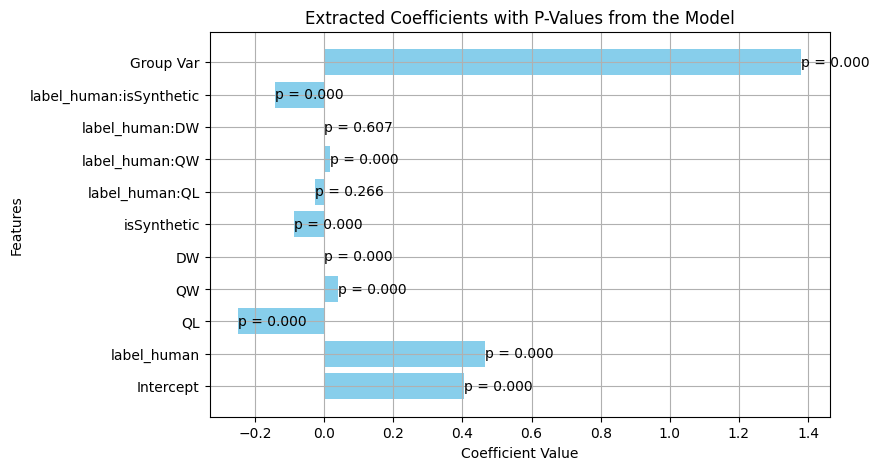

In [34]:
plot_coef(result)

In [ ]:
mixed_model_int = "score ~ isGPT4 + Judge + QL + QDR + QW + C(LLM, Treatment(reference='Other')) + C(Judge, Treatment(reference='nist')) * C(LLM, Treatment(reference='Other')) + isGPT4 * C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result = model.fit()
result.summary()

In [ ]:
real_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
real_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
mixed_model_condition_Qreal = "score ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline"
mixed_model_condition_Qsynthetic = "score ~ QL + QDS + QW + C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_real_judgments, groups=real_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_real_judgments, groups=synthetic_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_synthetic_judgments, groups=real_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_synthetic_judgments, groups=synthetic_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
real_queries_diff = pd.merge(real_queries_real_judgments, real_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
real_queries_diff['score_ab'] = real_queries_diff['score_a'] - real_queries_diff['score_b']
real_queries_diff['score_ba'] = real_queries_diff['score_b'] - real_queries_diff['score_a']

In [ ]:
real_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
synthetic_queries_diff = pd.merge(synthetic_queries_real_judgments, synthetic_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
synthetic_queries_diff['score_ab'] = synthetic_queries_diff['score_a'] - synthetic_queries_diff['score_b']
synthetic_queries_diff['score_ba'] = synthetic_queries_diff['score_b'] - synthetic_queries_diff['score_a']

In [ ]:
synthetic_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

## Extra Experiments (refer to: "Extra Exp. 1")

In [ ]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    return result_df

In [ ]:
real_judge_results = get_result(result_file="results/all.pass.nist.ndcgeval")
synthetic_judge_results = get_result(result_file="results/all.pass.gpt4.ndcgeval")

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [ ]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [ ]:
results_diff

Selected: score_SR

In [ ]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

In [ ]:
mixed_model_1 = "score_SR ~ Synthetic + QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')) + Synthetic * C(LLM, Treatment(reference='Other'))"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_1, results_diff, groups=results_diff["run_id"])
result = model.fit()
result.summary()